In [1]:
import glob
import math
import numpy as np
import os
import tensorflow as tf

2023-02-15 20:26:19.877318: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-15 20:26:20.505312: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.8/lib64:/usr/local/cuda-11.8/lib64
2023-02-15 20:26:20.505374: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.8/lib64:/usr/local/cuda-11.8/lib64
2023-02-15 20:26:20.50

In [2]:
os.listdir('images')

['f3', 'f1', 'f2']

In [10]:
spec_height = 256
spec_width = 256
model_name = 'vgg16'
patches = 3
input_path_proto = 'images/f%d/*.jpeg'
output_proto = 'out/f%d+n_patches%d'
n_folds = 3
n_folds = list(range(1, n_folds + 1))
patches = list([patches])

if not os.path.exists(output_proto):
    os.makedirs(output_proto)

## Extract features

In [4]:
def next_patch(spec, n):
    step = math.floor(spec.shape[0] / n)
    for i in range(n):
        yield spec[i * step:(i + 1) * step, :, :]


def get_model(model, **kwargs):
    if model == 'vgg16':
        return tf.keras.applications.vgg16.VGG16(**kwargs), tf.keras.applications.vgg16.preprocess_input
    if model == 'resnet50v2':
        return tf.keras.applications.resnet_v2.ResNet50V2(**kwargs), tf.keras.applications.resnet_v2.preprocess_input
    if model == 'mobilenetv2':
        return tf.keras.applications.mobilenet_v2.MobileNetV2(
            **kwargs), tf.keras.applications.mobilenet_v2.preprocess_input

    raise ValueError

In [12]:
os.environ["CUDA_VISIBLE_DEVICES"] = str(0)
for n_patches in patches:
    print("Slicing images into %d non-overlapping patches..." % (n_patches))
    tf.keras.backend.clear_session()

    input_shape = (math.floor(spec_height / n_patches), spec_width, 3)

    model, preprocess_input = get_model(model_name, weights='imagenet', include_top=False,
                                        input_shape=input_shape, pooling='avg')

    imgs_sliced = []
    for fold in n_folds:
        print("Extracting features for fold %d..." % (fold))
        if len(glob.glob(input_path_proto % (fold))) == 0:
            raise RuntimeError("No files found in: %s" % (input_path_proto % (fold)))

        features = []
        for fname in sorted(glob.glob(input_path_proto % (fold))):
            print(fname)
            img = tf.keras.preprocessing.image.load_img(fname)
            spec = tf.keras.preprocessing.image.img_to_array(img)
            for p in next_patch(spec, n_patches):
                p = preprocess_input(p)
                imgs_sliced.append(tf.keras.preprocessing.image.array_to_img(p))
                p = np.expand_dims(p, axis=0)
                features.append(model.predict(p))

        features = np.concatenate(features)
        print(fold, n_patches)
        output_filename = output_proto % (fold, n_patches)
        np.save(output_filename, features)
        print(output_filename, features.shape)

Slicing images into 3 non-overlapping patches...
Extracting features for fold 1...
images/f1/ALCB002449.jpeg
1/1 [==============================] - 0s 16ms/step
1 3
out/f1+n_patches3 (3, 512)
Extracting features for fold 2...
images/f2/ALCB002486.jpeg
1/1 [==============================] - 0s 15ms/step
2 3
out/f2+n_patches3 (3, 512)
Extracting features for fold 3...
images/f3/MBM143109.jpeg
1/1 [==============================] - 0s 17ms/step
3 3
out/f3+n_patches3 (3, 512)


## Example of data with features extracted

In [14]:
data = np.load('out/f1+n_patches3.npy')

import pandas as pd
pd.DataFrame(data)

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,0.000000,0.0,0.0,0.000000,0.000000,0.713208,5.38394,0.000000,0.0,0.0,...,0.000000,1.602357,3.370857,0.892535,5.489744,3.62922,0.567612,0.0,1.118160,0.0
1,6.053500,0.0,0.0,0.000000,0.908212,0.000000,0.00000,0.000000,0.0,0.0,...,1.759590,0.000000,20.015703,1.710024,0.530544,0.00000,0.000000,0.0,0.000000,0.0
2,12.777462,0.0,0.0,0.097234,3.959836,20.264071,0.00000,0.840035,0.0,0.0,...,0.246916,0.000000,20.130154,0.000000,0.000000,0.00000,0.000000,0.0,0.209513,0.0


## Example of image sliced

(-0.5, 255.5, 84.5, -0.5)

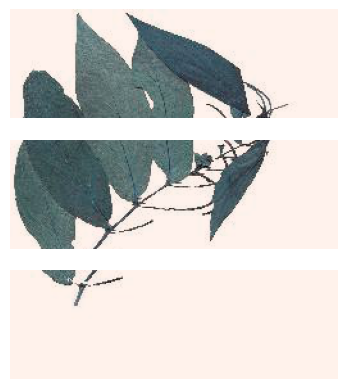

In [27]:
import matplotlib.pyplot as plt

fig = plt.figure()
fig.add_subplot(3, 1, 1)
plt.imshow(imgs_sliced[0], cmap='gray')
plt.axis('off')
fig.add_subplot(3, 1, 2)
plt.imshow(imgs_sliced[1], cmap='gray')
plt.axis('off')
fig.add_subplot(3, 1, 3)
plt.imshow(imgs_sliced[2], cmap='gray')
plt.axis('off')